In [1]:
#1
import matplotlib
from matplotlib import pylab
import pandas as pd
from import_data import import_legacy

#Specify columns for team_avgs calculation from following list:
    # ~~ Must always include Season, TeamID, Wins, Losses ~~
    # PPG, PAPG, RPG, APG, SPG, BPG, PFPG, TOPG, SOS, FGP
cols = ['Season', 'TeamID', 'Wins', 'Losses', 'PPG', 'PAPG', 'RPG', 'APG', 'SPG', 'BPG', 'PFPG', 'TOPG', 'SOS', 'FGP']

# Specify seasons to import data from, from 2006 to 2019 (inclusive)
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# import 2006-2019 regular season and tournament data, calculate team averages for tournament teams in each year
runtime, team_avgs, reg_season_df = import_legacy(cols, years)

print(f"Runtime: {runtime}\n")
print("Team Averages: \n", team_avgs)
print("All regular season matchups: \n", reg_season_df)

Runtime: 108.5249981880188

Team Averages: 
      Season  TeamID  Wins  Losses        PPG       PAPG        RPG        APG  \
0    2006.0  1104.0  17.0    12.0  69.965517  67.137931  37.000000  12.206897   
1    2006.0  1266.0  19.0    10.0  74.206897  69.655172  35.551724  15.275862   
2    2006.0  1130.0  25.0     7.0  74.531250  66.875000  35.187500  17.812500   
3    2006.0  1334.0  22.0     7.0  73.724138  63.586207  35.172414  15.655172   
4    2006.0  1181.0  30.0     3.0  82.515152  68.969697  32.909091  15.363636   
..      ...     ...   ...     ...        ...        ...        ...        ...   
891  2019.0  1205.0  20.0    11.0  75.774194  73.419355  32.870968  13.612903   
892  2019.0  1439.0  24.0     8.0  74.000000  62.093750  32.593750  15.343750   
893  2019.0  1387.0  23.0    12.0  67.057143  63.742857  39.771429  12.971429   
894  2019.0  1449.0  26.0     8.0  69.823529  64.382353  31.588235  11.676471   
895  2019.0  1429.0  27.0     6.0  79.030303  67.090909  40.0606

In [2]:
from import_data import import_year

runtime, team_avgs_2022, reg_2022_df = import_year(cols)

print(f"Runtime: {runtime}\n")
print("Team Averages: \n", team_avgs_2022)
print("All regular season matchups: \n", reg_2022_df)


Runtime: 0.48650074005126953

Team Averages: 
     Season  TeamID  Wins  Losses        PPG       PAPG        RPG        APG  \
0   2022.0  1211.0  26.0     3.0  87.827586  65.344828  41.482759  18.206897   
1   2022.0  1112.0  31.0     3.0  84.558824  67.529412  41.352941  19.911765   
2   2022.0  1242.0  28.0     6.0  78.588235  68.147059  37.352941  15.441176   
3   2022.0  1124.0  26.0     6.0  76.500000  63.625000  37.125000  15.843750   
4   2022.0  1120.0  27.0     5.0  78.718750  67.031250  39.937500  14.593750   
..     ...     ...   ...     ...        ...        ...        ...        ...   
63  2022.0  1313.0  24.0     6.0  75.100000  63.733333  38.766667  12.633333   
64  2022.0  1460.0  21.0    13.0  75.470588  71.058824  34.882353  13.941176   
65  2022.0  1136.0  22.0     9.0  77.903226  72.741935  41.548387  14.096774   
66  2022.0  1411.0  18.0    12.0  69.233333  65.500000  39.533333  10.833333   
67  2022.0  1394.0  23.0    11.0  76.911765  69.941176  38.352941  15.029

In [8]:
#2

#SoS Calculation
def SoS_calc(input_df, output_df, year_range = years): # input_df is the game by game df, output_df is the team_avgs df
    
    sos_dict = {}
    input_df['Season'] = pd.to_numeric(input_df['Season'])
    
    for year in year_range:
        working_df = input_df[input_df['Season'] == year]
        working_df = working_df.filter(["WTeamID", "LTeamID"])

        for row in working_df.itertuples(index=False):
            winner = int(row[0])
            loser = int(row[1])

            if winner not in sos_dict:
                temp_sos = {"opp_list": [loser], "wins" : 1, "losses" : 0, "win%" : 0, "ow%" : 0, "oow%" : 0, "sos" : 0}
                sos_dict[winner] = temp_sos.copy()
                temp_sos.clear()
            else:
                sos_dict[winner]["opp_list"].append(loser)
                sos_dict[winner]["wins"] += 1

            if loser not in sos_dict:
                temp_sos = {"opp_list": [winner], "wins" : 0, "losses" : 1, "win%" : 0, "ow%" : 0, "oow%" : 0, "sos" : 0}
                sos_dict[loser] = temp_sos.copy()
                temp_sos.clear()                    
            else:
                sos_dict[loser]["opp_list"].append(winner)
                sos_dict[loser]["losses"] += 1

        for calc in ["win%", "ow%", "oow%", "sos"]:
            for k, d in sos_dict.items():
                if calc == "win%":
                    d["win%"] = d["wins"] / (d["wins"] + d["losses"])

                if calc == "ow%":
                    sum_wp = 0
                    num = 0
                    for opp in d["opp_list"]:
                        sum_wp += sos_dict[opp]["win%"]
                        num += 1
                    d["ow%"] = (sum_wp / num)

                if calc == "oow%":
                    sum_ow = 0
                    num = 0
                    for opp in d["opp_list"]:
                        sum_ow += sos_dict[opp]["ow%"]
                        num += 1
                    d["oow%"] = (sum_ow / num)
                    d["sos"] = (d["ow%"] * 2 + d["oow%"]) / 3


        sos_year_df = output_df[output_df["Season"] == year]
        team_list = sos_year_df["TeamID"].tolist()
        for row in output_df[output_df["Season"] == year].itertuples():
            output_df.iat[row.Index, output_df.columns.get_loc("SOS")] = sos_dict[row[2]]["sos"]



        sos_dict.clear()
            
        
    return output_df
        
team_avgs = SoS_calc(reg_season_df, team_avgs)
print(team_avgs)
team_avgs_2022 = SoS_calc(reg_2022_df, team_avgs_2022, [2022])
print(team_avgs_2022)

   Season  TeamID  Wins  Losses        PPG       PAPG   RPG        APG  \
0  2006.0  1104.0  17.0    12.0  69.965517  67.137931  37.0  12.206897   

        SPG       BPG       PFPG       TOPG      SOS       FGP  
0  6.344828  5.034483  13.827586  13.517241  0.57859  0.453444  
    Season  TeamID  Wins  Losses        PPG       PAPG        RPG        APG  \
0   2022.0  1211.0  26.0     3.0  87.827586  65.344828  41.482759  18.206897   
1   2022.0  1112.0  31.0     3.0  84.558824  67.529412  41.352941  19.911765   
2   2022.0  1242.0  28.0     6.0  78.588235  68.147059  37.352941  15.441176   
3   2022.0  1124.0  26.0     6.0  76.500000  63.625000  37.125000  15.843750   
4   2022.0  1120.0  27.0     5.0  78.718750  67.031250  39.937500  14.593750   
..     ...     ...   ...     ...        ...        ...        ...        ...   
63  2022.0  1313.0  24.0     6.0  75.100000  63.733333  38.766667  12.633333   
64  2022.0  1460.0  21.0    13.0  75.470588  71.058824  34.882353  13.941176   
6

In [3]:
#3
import random

random.seed()

# make a new empty dataframe to hold all of the data

# note: "Winner" column will always be '1' because the winning team is always listed first;
# it's included just for a classification metric for the machine learning
train_cols = ["Season", "Team1ID", "Team2ID", "Winner", "Team1W", "Team1L", "Team1PPG", "Team1PAPG", "Team1RPG", "Team1APG", "Team1SPG", \
              "Team1BPG", "Team1PFPG", "Team1TOPG", "Team1SOS", "Team1FGP", "Team2W", "Team2L", "Team2PPG", "Team2PAPG", "Team2RPG", "Team2APG", "Team2SPG",\
              "Team2BPG", "Team2PFPG", "Team2TOPG", "Team2SOS", "Team2FGP"]



# we just need three columns from our tourney_df
trim_tourney_df = tourney_df[["Season", "WTeamID", "LTeamID"]]
trim_tourney_df



def trainingData():
    train_DF_temp = pd.DataFrame(columns=train_cols)
    for year in years:
        avg_year_df = team_avgs[team_avgs['Season'] == year]
        seeds_year_df = seeds_df[seeds_df['Season'] == year]
        tourney_year_df = trim_tourney_df[trim_tourney_df['Season'] == year].apply(pd.to_numeric)

        for index, row in tourney_year_df.iterrows():
            # make a list that we can insert into the new dataframe
            #first 4 values (last value is the "Winner" classification which is randomly chosen)
            team1_seed = seeds_year_df[seeds_year_df['TeamID'] == row["WTeamID"]].values.tolist()[0][1]
            team2_seed = seeds_year_df[seeds_year_df['TeamID'] == row["LTeamID"]].values.tolist()[0][1]
            team1_prefix = team1_seed[0:1]
            team2_prefix = team2_seed[0:1]
            
            team1_seed = int(team1_seed[1:3])
            team2_seed = int(team2_seed[1:3])
            
            #choose which team is first based on seed
            winning_team = 2
            losing_team = 1
            
            if team1_seed < team2_seed:
                winning_team = 1
                losing_team = 2
            elif team2_seed == team1_seed:
                if team1_prefix > team2_prefix:
                    winning_team = 1
                    losing_team = 2
                    

            #properly put winning team into correct row
            team_id = ["", "WTeamID", "LTeamID"]
            temp_list = [year, row[team_id[winning_team]], row[team_id[losing_team]], winning_team]
            team1_row = avg_year_df[avg_year_df["TeamID"] == temp_list[1]][cols[2:]].values.tolist()
            team2_row = avg_year_df[avg_year_df["TeamID"] == temp_list[2]][cols[2:]].values.tolist()
            temp_list.extend(team1_row[0])
            temp_list.extend(team2_row[0])

            # add that list to our DF
            temp_series = pd.Series(temp_list, index=train_cols)
            train_DF_temp = train_DF_temp.append(temp_series, ignore_index=True)
    return train_DF_temp

train_DF = trainingData()
print(train_DF)

train_data = train_DF[train_DF['Season'] >= 2010]
train_labels = train_data['Winner']
train_data = train_data.drop(columns=['Winner'])



#train_data
        
        

    

     Season  Team1ID  Team2ID  Winner  Team1W  Team1L   Team1PPG  Team1PAPG  \
0    2006.0   1266.0   1104.0     2.0    19.0    10.0  74.206897  69.655172   
1    2006.0   1130.0   1334.0     1.0    25.0     7.0  74.531250  66.875000   
2    2006.0   1181.0   1380.0     1.0    30.0     3.0  82.515152  68.969697   
3    2006.0   1196.0   1375.0     1.0    27.0     6.0  79.272727  64.787879   
4    2006.0   1203.0   1423.0     1.0    26.0     2.0  78.964286  66.678571   
..      ...      ...      ...     ...     ...     ...        ...        ...   
877  2019.0   1246.0   1120.0     2.0    27.0     6.0  76.727273  65.424242   
878  2019.0   1181.0   1277.0     2.0    29.0     5.0  83.500000  67.558824   
879  2019.0   1277.0   1403.0     2.0    28.0     6.0  78.823529  65.529412   
880  2019.0   1438.0   1120.0     1.0    29.0     3.0  71.843750  55.062500   
881  2019.0   1438.0   1403.0     1.0    29.0     3.0  71.843750  55.062500   

      Team1RPG   Team1APG  ...   Team2PPG  Team2PAP

In [4]:
#4
d = {'Team1ID': [1211,1129,1163,1116,1104,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1246,1112,1371,1222,1228,1161,1397,1326,1437,1242,1361,1234,1344,1261,1458,1425,1120,1211,1116,1403,1181,1124,1417,1345,1293,1112,1228,1397,1437,1242,1344,1458,1120,1211,1181,1417,1345,1112,1437,1242,1274,1181,1314,1437,1242,1181,1242,1242], 'Team2ID': [1209,1272,1308,1436,1323,1286,1172,1168,1313,1266,1231,1103,1439,1463,1362,1389,1460,1395,1412,1151,1276,1255,1260,1174,1411,1166,1350,1355,1235,1159,1274,1240,1272,1308,1323,1277,1314,1388,1400,1389,1395,1222,1276,1326,1166,1350,1235,1274,1116,1403,1314,1389,1222,1276,1344,1235,1116,1389,1222,1274,1314,1437,1314]}
test_cols = ["Season", "Team1ID", "Team2ID", "Team1W", "Team1L", "Team1PPG", "Team1PAPG", "Team1RPG", "Team1APG", "Team1SPG", \
              "Team1BPG", "Team1PFPG", "Team1TOPG", "Team1SOS", "Team1FGP", "Team2W", "Team2L", "Team2PPG", "Team2PAPG", "Team2RPG", "Team2APG", "Team2SPG",\
              "Team2BPG", "Team2PFPG", "Team2TOPG", "Team2SOS", "Team2FGP"]
temp_tourn_df = pd.DataFrame(data=d)
#winners = [2,1,1,2,1,2,2,1,2,1,1,1,1,2,1,1,1,1,1,2,1,2,1,1,2,1,1,1,1,2,2,1,2,1,2,1,1,2,2,2,2,2,2,2,1,1,1,2,1,2,1,1,2,2,1,2,2,2,1,2,2,1,2,1,2,2,2]
tourney_2022_df = pd.DataFrame(columns=test_cols)

for row in temp_tourn_df.iterrows():
    #Doing the same as before but without winner column
    temp_list = [2022, row[1]['Team1ID'], row[1]['Team2ID']]
    print(f"team2: ", row[1]['Team2ID'])
    team1_row = team_avgs_2022[team_avgs_2022["TeamID"] == row[1]['Team1ID']].values.tolist()
    team2_row = team_avgs_2022[team_avgs_2022["TeamID"] == row[1]['Team2ID']].values.tolist()
    print(team2_row)
    team1_row[0].pop(0)
    team1_row[0].pop(0)
    team2_row[0].pop(0)
    team2_row[0].pop(0)

    temp_list.extend(team1_row[0])
    temp_list.extend(team2_row[0])
        
    # add that list to our DF
    temp_series = pd.Series(temp_list, index=test_cols)
    tourney_2022_df = tourney_2022_df.append(temp_series, ignore_index=True)

tourney_2022_df

team2:  1209
[[2022.0, 1209.0, 18.0, 10.0, 70.60714285714286, 64.75, 37.25, 13.535714285714286, 8.928571428571429, 4.464285714285714, 15.75, 11.857142857142858, 0.37275651662941583, 0.40264976958525345]]
team2:  1272
[[2022.0, 1272.0, 21.0, 10.0, 75.41935483870968, 68.38709677419355, 38.74193548387097, 16.06451612903226, 8.709677419354838, 5.67741935483871, 18.70967741935484, 16.35483870967742, 0.4246561585342099, 0.47068771138669674]]
team2:  1308
[[2022.0, 1308.0, 26.0, 6.0, 73.3125, 65.03125, 38.46875, 13.90625, 5.0625, 4.15625, 15.875, 14.0, 0.3758759162823933, 0.4574585635359116]]
team2:  1436
[[2022.0, 1436.0, 28.0, 5.0, 74.93939393939394, 60.303030303030305, 35.09090909090909, 15.212121212121213, 5.212121212121212, 2.515151515151515, 13.787878787878787, 9.696969696969697, 0.38604185264221097, 0.49349240780911063]]
team2:  1323
[[2022.0, 1323.0, 22.0, 10.0, 72.5, 66.84375, 34.0625, 14.15625, 5.09375, 1.875, 12.875, 10.34375, 0.43769248767808744, 0.4623955431754875]]
team2:  1286


,Season,Team1ID,Team2ID,Team1W,Team1L,Team1PPG,Team1PAPG,Team1RPG,Team1APG,Team1SPG,...,Team2PPG,Team2PAPG,Team2RPG,Team2APG,Team2SPG,Team2BPG,Team2PFPG,Team2TOPG,Team2SOS,Team2FGP
0,2022.0,1211.0,1209.0,26.0,3.0,87.827586,65.344828,41.482759,18.206897,6.655172,...,70.607143,64.750000,37.250000,13.535714,8.928571,4.464286,15.750000,11.857143,0.372757,0.402650
1,2022.0,1129.0,1272.0,27.0,7.0,68.705882,60.764706,34.970588,11.529412,5.911765,...,75.419355,68.387097,38.741935,16.064516,8.709677,5.677419,18.709677,16.354839,0.424656,0.470688
2,2022.0,1163.0,1308.0,23.0,9.0,75.187500,65.156250,40.875000,14.000000,5.968750,...,73.312500,65.031250,38.468750,13.906250,5.062500,4.156250,15.875000,14.000000,0.375876,0.457459
3,2022.0,1116.0,1436.0,25.0,8.0,76.939394,68.545455,38.151515,14.090909,7.727273,...,74.939394,60.303030,35.090909,15.212121,5.212121,2.515152,13.787879,9.696970,0.386042,0.493492
4,2022.0,1104.0,1323.0,19.0,13.0,79.968750,76.406250,39.968750,14.625000,7.000000,...,72.500000,66.843750,34.062500,14.156250,5.093750,1.875000,12.875000,10.343750,0.437692,0.462396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,2022.0,1437.0,1222.0,26.0,7.0,72.636364,63.090909,34.939394,12.060606,6.242424,...,75.823529,58.882353,39.235294,16.735294,8.235294,5.205882,17.382353,11.323529,0.403810,0.468888
59,2022.0,1242.0,1274.0,28.0,6.0,78.588235,68.147059,37.352941,15.441176,6.411765,...,74.818182,71.030303,30.454545,14.030303,8.727273,2.939394,14.939394,9.606061,0.415655,0.478192
60,2022.0,1181.0,1314.0,28.0,6.0,80.176471,67.147059,38.294118,16.911765,6.470588,...,77.515152,71.727273,39.757576,14.818182,5.424242,3.848485,14.363636,11.666667,0.446561,0.452830
61,2022.0,1242.0,1437.0,28.0,6.0,78.588235,68.147059,37.352941,15.441176,6.411765,...,72.636364,63.090909,34.939394,12.060606,6.242424,2.272727,15.242424,10.000000,0.489467,0.437029


In [5]:
#5
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt
import numpy as np

train_DF = trainingData()

In [6]:
#6
winners = [1,2,2,1,2,1,1,1,1,1,1,1,1,1,1,2,1,2,1,1,2,1,1,1,1,2,2,1,2,1,2,1,1,1,1,1,2,1,1,2,1,2,2,1,1,1,2,2,2,1,2,2,2,1,1,1,1,1,1,1,2,1,1]
vegas_winners = [1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,2,1,1,1,1]

vright = 0
vwrong = 0
print(len(vegas_winners))
print(len(winners))
for i in range(0,len(vegas_winners)):
    if vegas_winners[i] == winners[i]:
        vright += 1
    else:
        vwrong += 1

#print(f"# of Games correct: ",right)
#print(f"# of Games missed: ",wrong)
#print(f"Accuracy: ", (right) / (right + wrong))

print(f"Vegas # of Games correct: ",vright)
print(f"Vegas # of Games missed: ",vwrong)
print(f"Vegas Accuracy: ", (vright) / (vright + vwrong))

63
63
Vegas # of Games correct:  35
Vegas # of Games missed:  28
Vegas Accuracy:  0.5555555555555556


In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

def accuracy(preds):
    right = 0
    wrong = 0
    for i in range(0,len(preds)):
        if preds[i] == winners[i]:
            right += 1
        else:
            wrong += 1
    return right / (right + wrong)

bayes_model = MultinomialNB().fit(train_data, train_labels)
bayes_preds = bayes_model.predict(tourney_2022_df)
print(f"Naive Bayes: ", accuracy(bayes_preds))

tree_model = DecisionTreeClassifier().fit(train_data, train_labels)
tree_preds = tree_model.predict(tourney_2022_df)
print(f"Decision Tree: ", accuracy(tree_preds))

forest_model = RandomForestClassifier().fit(train_data, train_labels)
forest_preds = forest_model.predict(tourney_2022_df)
print(f"Random Forest: ", accuracy(forest_preds))



Naive Bayes:  0.5555555555555556
Decision Tree:  0.5873015873015873
Random Forest:  0.6666666666666666


In [19]:
#7
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn import svm

xgb.set_config(verbosity=0)

def trainAndPredictXGB(classifier, test_df, sampleSize, num_games):

    predicted_games = [0] * num_games

    for i in range(sampleSize):

        train_df_year = train_DF[train_DF['Season'] >= 2010]

        X = train_df_year.drop("Season", axis=1)
        X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
        y = train_df_year["Winner"]
        y = y.astype(int)

        test_X = test_df.drop(["Season", "Team1ID", "Team2ID"], axis=1)
        #print(test_X)

        scaler = StandardScaler()
        scaled_X = scaler.fit_transform(X.values)
        scaled_test = scaler.fit_transform(test_X.values)
        X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)
        test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)
        
        #C_range = np.logspace(-2, 10, 13)
        #gamma_range = np.logspace(-9, 3, 13)
        #param_grid = dict(gamma=gamma_range, C=C_range)
        #cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
        #grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
        #grid.fit(X, y)

        #print(
        #    "The best parameters are %s with a score of %0.2f"
        #    % (grid.best_params_, grid.best_score_)
        #)

        classifier.fit(X_proc, y)

        preds = classifier.predict(test_proc)
        for i in range(len(preds)):
            if preds[i] == 1:
                predicted_games[i] += 1
        
    overall_pred = [1] * num_games
    for i in range(len(predicted_games)):
        #print(f"# Games: {predicted_games[i]}, sample_size: {sampleSize/2}")
        if predicted_games[i] < (sampleSize / 2):
            #print(f"Ovr Prediction: {overall_pred[i]}")
            overall_pred[i] = 2
    #print(overall_pred)
    return overall_pred
    
#for i in range(100):
    #svm_total += trainAndPredictXGB(svm.SVC())

In [20]:
def predictYear(classifier, year, num_games):
    
    predicted_games = [0] * num_games
    
    test_data = train_DF[train_DF['Season'] == year]
    test_labels = test_data['Winner']
    test_data = test_data.drop(columns=['Winner'])

    training_data = train_DF[train_DF['Season'] != year]
    y = training_data['Winner']

    test_X = test_data.drop(["Season", "Team1ID", "Team2ID"], axis=1)
    X = training_data.drop("Season", axis=1)
    X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
    y = y.astype(int)

    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X.values)
    scaled_test = scaler.fit_transform(test_X.values)
    test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)

    X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)

    accuracy_scores = []
    from sklearn.metrics import accuracy_score

    # Model Fit
    classifier.fit(X_proc, y)

    # Model Prediction
    preds = classifier.predict(test_proc)

    #print(overall_pred)

    # Accuracy Score
    #print(preds)
    return accuracy_score(test_labels, preds)

acc_scores = []
for year in years:
    if year > 2010:
        score = predictYear(svm.SVC(C=4.6, gamma=0.01), year, 63)
        acc_scores.append(score)
print(f"Avg Accuracy: {sum(acc_scores) / len(acc_scores)}")


        

Avg Accuracy: 0.7054673721340388


In [21]:
#9

svm_preds = trainAndPredictXGB(svm.SVC(C=4.2, gamma=0.01), tourney_2022_df, 1, 63)
print(accuracy(svm_preds))

dt_preds = trainAndPredictXGB(DecisionTreeClassifier(), tourney_2022_df, 25, 63)
print(accuracy(dt_preds))

rf_preds = trainAndPredictXGB(RandomForestClassifier(), tourney_2022_df, 25, 63)
print(accuracy(rf_preds))

#xgb_preds = trainAndPredictXGB(xgb.XGBClassifier(), tourney_2022_df, 1, 63)
#print(accuracy(xgb_preds))


0.6507936507936508
0.5873015873015873
0.6507936507936508


In [24]:
#10
firstRound = {'Team1ID': [1211,1129,1163,1116,1104,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1246,1112,1371,1222,1228,1161,1397,1326,1437,1242,1361,1234,1344,1261,1458,1425,1120], 'Team2ID': [1209,1272,1308,1436,1323,1286,1172,1168,1313,1266,1231,1103,1439,1463,1362,1389,1460,1395,1412,1151,1276,1255,1260,1174,1411,1166,1350,1355,1235,1159,1274,1240]}
tournamentRounds = {'Round1': [1211,1272,1308,1116,1323,1403,1277,1181,1124,1314,1388,1417,1400,1345,1293,1389,1112,1395,1222,1228,1276,1397,1326,1437,1242,1166,1350,1344,1235,1458,1274,1120], \
                    'Round2': [1211,1116,1403,1181,1314,1417,1345,1389,1112,1222,1276,1437,1242,1344,1235,1274], \
                    'Round3': [1116,1181,1314,1389,1222,1437,1242,1274], \
                    'Round4': [1181,1314,1437,1242], 'Round5': [1314, 1242], 'Round6': [1242]}
seed_dict = {1211: 'W01', 1209: 'W16', 1129: 'W08', 1272: 'W09', 1163: 'W05', 1308: 'W12', 1116: 'W04', 1436: 'W13', 1104: 'W06', 1323: 'W11', 1403: 'W03', 1286: 'W14', 1277: 'W07', 1172: 'W10', 1181: 'W02', 1168: 'W15', 1124: 'X01', 1313: 'X16', 1314: 'X08', 1266: 'X09', 1388: 'X05', 1231: 'X12', 1417: 'X04', 1103: 'X13', 1400: 'X06', 1439: 'X11', 1345: 'X03', 1463: 'X14', 1293: 'X07', 1362: 'X10', 1246: 'X02', 1389: 'X15', 1112: 'Y01', 1460: 'Y16', 1371: 'Y08', 1395: 'Y09', 1222: 'Y05', 1412: 'Y12', 1228: 'Y04', 1151: 'Y13', 1161: 'Y06', 1276: 'Y11', 1397: 'Y03', 1255: 'Y14', 1326: 'Y07', 1260: 'Y10', 1437: 'Y02', 1174: 'Y15', 1242: 'Z01', 1411: 'Z16', 1361: 'Z08', 1166: 'Z09', 1234: 'Z05', 1350: 'Z12', 1344: 'Z04', 1355: 'Z13', 1261: 'Z06', 1235: 'Z11', 1458: 'Z03', 1159: 'Z14', 1425: 'Z07', 1274: 'Z10', 1120: 'Z02', 1240: 'Z15'}
bracket_df = pd.DataFrame(data=firstRound)

def tournament(classifier, round_bracket, round_num, bracket_score):
    round_df = pd.DataFrame(columns=test_cols)
    for row in round_bracket.iterrows():
        temp_list = [2022, row[1]['Team1ID'], row[1]['Team2ID']]
        
        #ordering new teams by seed
        if round_num > 1:
            team1_seed = seed_dict[temp_list[1]]
            team2_seed = seed_dict[temp_list[2]]

            
            team1_prefix = team1_seed[0:1]
            team2_prefix = team2_seed[0:1]

            team1_seed = int(team1_seed[1:3])
            team2_seed = int(team2_seed[1:3])
            
            if team1_seed > team2_seed:
                temp = temp_list[1]
                temp_list[1] = temp_list[2]
                temp_list[2] = temp
                
                
        #print(temp_list)
        team1_row = team_avgs_2022[team_avgs_2022["TeamID"] == temp_list[1]].values.tolist()
        team2_row = team_avgs_2022[team_avgs_2022["TeamID"] == temp_list[2]].values.tolist()
        team1_row[0].pop(0)
        team1_row[0].pop(0)
        team2_row[0].pop(0)
        team2_row[0].pop(0)

        temp_list.extend(team1_row[0])
        temp_list.extend(team2_row[0])
        # add that list to our DF
        temp_series = pd.Series(temp_list, index=test_cols)
        round_df = round_df.append(temp_series, ignore_index=True)
        
    #print(round_df)
    preds = trainAndPredictXGB(classifier, round_df, 1, len(round_df.index))
    
    #if(round_num == 1):
        #return;
    
    round_dict = {'Team1ID': [], 'Team2ID': []}
    winners_arr = []
    for i in range(0, len(preds)):
        if i % 2 == 0:
            length = len(round_dict['Team1ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team1ID'].append(val)
            winners_arr.append(val)
        else:
            length = len(round_dict['Team2ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team2ID'].append(val)
            winners_arr.append(val)
    for i in range(0, len(winners_arr)):
        #print(f"Predicted: {winners_arr[i]}  Real: {tournamentRounds['Round' + str(round_num)][i]}")
        if winners_arr[i] == tournamentRounds['Round' + str(round_num)][i]:
            bracket_score += 10 * (2**(round_num - 1))
            #print(bracket_score)
    if round_num < 6:
        new_df = pd.DataFrame(data=round_dict)
        tournament(classifier, new_df, round_num+1, bracket_score)
    else:
        print(bracket_score)
        
tournament(svm.SVC(C=4.6, gamma=0.01), bracket_df, 1, 0)

#xgboost    
#eta-[0.05, 0.06, 0.11, 0.13, .15]

880


Average of 500 coin flip brackets: 315.54


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5f7b1ef310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5f7b1efd00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5fa17a6640>],
 'medians': [<matplotlib.lines.Line2D at 0x7f5f7b1b3400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f5fa17a68b0>],
 'means': []}

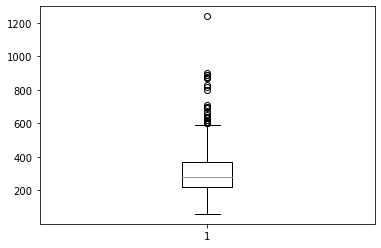

In [25]:
from random import randint

actual_winners = ( #Teams are given an index starting at the top left and ending at the bottom right
      [], #placeholder so each round can have the right index
      [0,3,5,6,9,10,12,14,16,18,20,22,24,26,28,31,32,35,36,38,41,42,44,46,48,51,53,54,57,58,61,62], #rd 1
      [0,6,10,14,18,22,26,31,32,36,41,46,48,54,57,61], #rd 2
      [6,14,18,31,36,46,48,61], #rd 3 (E8)
      [14,18,46,48], #rd 4 (F4)
      [18,48], #rd 5 (final)
      [48]) #rd 6 (winner)

# coin-flip bracket
def pick_round(teams):
    loser_list = []
    
    for i in range(0, len(teams) - 1, 2):
        loser_list.append(i + randint(0,1)) # get a list of random losers
        
    loser_list.reverse() #reverse the list so it's in reverse numerical order (so we can remove by index)
    for loser in loser_list:
        teams.pop(loser)
        
    return teams

def coin_flip(actual_winners):
    sim_tourney = list(range(0, 64))
    predicted_winners = [[]]
    score = 0
    
    for rd in range(1,7):
        sim_tourney = pick_round(sim_tourney)
        predicted_winners.append(sim_tourney[:])
    
    for rd in range(1,7):
        for game in range(0, len(predicted_winners[rd])):
            score = (score + 10 * (2 ** (rd - 1))) if predicted_winners[rd][game] == actual_winners[rd][game] else score
        
    return score

coin_flips = []

num_coin_flips = 500
for i in range(0, num_coin_flips):
    coin_flips.append(coin_flip(actual_winners))
    
print(f"Average of {num_coin_flips} coin flip brackets: {sum(coin_flips) / len(coin_flips)}")
    
from matplotlib import pyplot

pyplot.boxplot(coin_flips)

    

In [30]:
def predictByYear(classifier, round_df, year, num_games):
    
    predicted_games = [0] * num_games
    
    test_data = round_df

    training_data = train_DF[train_DF['Season'] != year]
    y = training_data['Winner']

    test_X = test_data.drop(["Season", "Team1ID", "Team2ID"], axis=1)
    X = training_data.drop("Season", axis=1)
    X = X.drop(["Winner", "Team1ID", "Team2ID"], axis=1)
    y = y.astype(int)

    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X.values)
    scaled_test = scaler.fit_transform(test_X.values)
    test_proc = pd.DataFrame(scaled_test, index = test_X.index, columns = test_X.columns)

    X_proc = pd.DataFrame(scaled_X, index = X.index, columns = X.columns)

    accuracy_scores = []
    from sklearn.metrics import accuracy_score

    # Model Fit
    classifier.fit(X_proc, y)

    # Model Prediction
    preds = classifier.predict(test_proc)
    return preds
    
def tourneyByYear(classifier, round_bracket, round_num, start_index, bracket_score, year):
    round_df = pd.DataFrame(columns=test_cols)
    for row in round_bracket.iterrows():
        temp_list = [2022, row[1]['Team1ID'], row[1]['Team2ID']]
        seeds_year_df = seeds_df[seeds_df['Season'] == year]
        
        #ordering new teams by seed
        if round_num > 1:
            #print(row[1])
            team1_seed = seeds_year_df[seeds_year_df['TeamID'] == row[1]["Team1ID"]].values.tolist()[0][1]
            team2_seed = seeds_year_df[seeds_year_df['TeamID'] == row[1]["Team2ID"]].values.tolist()[0][1]
            team1_prefix = team1_seed[0:1]
            team2_prefix = team2_seed[0:1]
            
            team1_seed = int(team1_seed[1:3])
            team2_seed = int(team2_seed[1:3])
            
            if team1_seed > team2_seed:
                temp = temp_list[1]
                temp_list[1] = temp_list[2]
                temp_list[2] = temp
                
                
        #print(temp_list)
        team1_row = team_avgs[team_avgs['Season'] == year]
        team1_row = team_avgs[team_avgs["TeamID"] == temp_list[1]].values.tolist()
        
        team2_row = team_avgs[team_avgs['Season'] == year]
        team2_row = team_avgs[team_avgs["TeamID"] == temp_list[2]].values.tolist()
        team1_row[0].pop(0)
        team1_row[0].pop(0)
        team2_row[0].pop(0)
        team2_row[0].pop(0)

        temp_list.extend(team1_row[0])
        temp_list.extend(team2_row[0])
        # add that list to our DF
        temp_series = pd.Series(temp_list, index=test_cols)
        round_df = round_df.append(temp_series, ignore_index=True)
        
    preds = predictByYear(classifier, round_df, 1, len(round_df.index))
    
    round_dict = {'Team1ID': [], 'Team2ID': []}
    winners_arr = []
    for i in range(0, len(preds)):
        if i % 2 == 0:
            length = len(round_dict['Team1ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team1ID'].append(val)
            winners_arr.append(val)
        else:
            length = len(round_dict['Team2ID'])
            val = 0
            if preds[i] == 1:
                val = round_df.iloc[i]['Team1ID']
            else:
                val = round_df.iloc[i]['Team2ID']
                
            round_dict['Team2ID'].append(val)
            winners_arr.append(val)
    tourney_year = trim_tourney_df[trim_tourney_df['Season'] == year].apply(pd.to_numeric)
    for i in range(0, len(winners_arr)):
        new_row = tourney_year.iloc[start_index + i]
        if winners_arr[i] == new_row['WTeamID']:
            bracket_score += 10 * (2**(round_num - 1))
    if round_num < 6:
        new_df = pd.DataFrame(data=round_dict)
        return tourneyByYear(classifier, new_df, round_num+1, start_index + int(32 / (2**round_num-1)), bracket_score, year)
    else:
        print(bracket_score)
        return bracket_score
        

historical_scores = []
for year in years:
    if(year > 2010):
        old_round_df = train_DF[train_DF['Season'] == year]
        old_round_df = old_round_df.head(32)
        historical_scores.append(tourneyByYear(svm.SVC(C=4.6, gamma=0.01), old_round_df,1,0,0,year))
print(f"Avg Bracket Score: {sum(historical_scores) / len(historical_scores)}")

270
420
300
320
740
430
680
250
580
Avg Bracket Score: 443.3333333333333
